# Causal Structure Discovery and Inference

## Abstract 

Causal Structure Discovery (CSD) is the problem of identifying causal relationships from large quantities of data through computational methods. Causality or Causation is defined as a relationship between two events, states, process or objects such that changes in one event, state, process or object lead to changes in another. In genral these events, states, process or objects are represented by variables such as X & Y. The key difference between association and causation lies in the potential of confounding. Suppose that no direct causal relationship exists between X and Y but rather a third variable Z causes both X and Y. In this case, even though X and Y are strongly associated, altering X will not lead to changes in Y. Z is called a confounder. In an experimental setup if intervening on a variable X leads changes to Y then causality can be established as X causes Y. However in the real world we cannot intervening on certain systems due to risk, cost or ethical concerns. Such systems include but not limited to climate, environment, biology, social etc. In systems like these studies are conducted purely based on observational data. Extracting causal structure through these observational data while adjusting for confounding has been a challenge for many scientfic disciplines. Many machine learning methods have been proposed for this problem but they are largely based on associations. In this article we will explore the methods and challenges involved in CSD and also experiment regression based methods to extract underlying causal structure and infer future states of a given system. 

## 1. Introduction

Causation is a direct effect between variable X and Y that remains after adjusting for confounding. Confounding can be observed or unobserved. Since the seventeeth century modern science, we have had two kinds of scientific methods for discovering causes. The first method involved manipulating and varying features of a system to see what other features do or donot change. While there are many experiments that fit this methods perhaps the most famous one is Pavlov's classical conditioning experiment, where he established a stimulus-response connection. These methods shone brightly but manipulating systems like live animals or environments are bounded by ethics and costs. The notiorious expriments like Tuskegee study and prision expreiments amoung others have shown us why the intervention methods are dangerous. The other scientific methods for discovering causes involved observing the variation of features of system without manupulation. In these methods observational data will be collected for a system and just by observing who different attributes of a system changes causal connections can be established between different parts of the system. Some examples, include discovering astronomical objects through observational data or connecting weather patterns through remote sensing data.

## 2. Graphical Causal Model

R.A Fisher's work on experimental design showed how randomizing break confounding, whether due to observed or un-observed common cause.

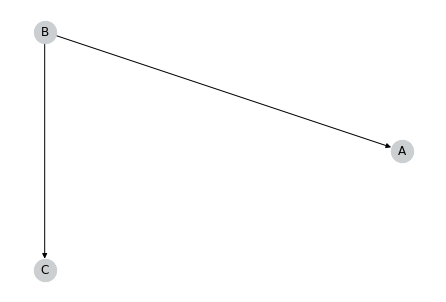

In [12]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_edge('B', 'A')
G.add_edge('B', 'C')
nx.draw(G, with_labels=True,
        node_size=500,
        node_color="#CBCFD1",
        pos=nx.circular_layout(G))

## 3. Causal Inference and Simposon's paradox.

In many data we often encounter a weried scenario where an event $C$ increases the probablity $E$ in a given population $P$ and at the same time decreases probablity $E$ in every sub population of $p$. If $F$ and $\neg F$ are two complementary properties of subpopulation then there might be a scenariors where the following statements are true.

\begin{equation*}
P(E|C) > P(E|\neg C)
\end{equation*}

and

\begin{equation*}
P(E|C, F) < P(E|\neg C, F)
\end{equation*}
\begin{equation*}
P(E|C, \neg F) < P(E|\neg C, \neg F)
\end{equation*}

These statements seems counter intutive and paradoxical, but however upon establishing causal relationship to variables there will be a confounding variable which would explain the statements. Techincally Simposon's paradox is not a paradox but a misrepresentation of the statement and not accounting counfounders. statment $P(E|C)$ seems to sugguest $C$ to have a causal relation with $E$ but however its a mere evidence that when $C$ is done it seems to have assosicated results with $E$ and it doesn't imply it has a causal relation with $E$. To represent the above statments correctly we will use Pearson's do operator. 

\begin{equation*}
P(E|do(C)) > P(E|\neg do(C))
\end{equation*}

This property of data can be dangerous as they can lead us to make wrong conclusion. It is very important to establish causal relationships before drawing conclusion. Every question related to effect of action must be decided by causal considerational and not statistical information alone. This enstates the epistemological view that reason should be the chief source and test of knowledge and not the observation alone.


## 4. Methods of Causal Disovery

### 4.1 Score based

### 4.2 Constraint based

## 4. Modeling a spring particle system through a causal graph

In [1]:
import torch
import simulation
sim = simulation.Spring(num_particles=4, dynamics='static', min_steps=500, max_steps=1000)

Collect few observations

In [6]:
def get_observations(n=5):
    observations = []
    for _ in range(n):
        observations.append(sim.sample_trajectory(total_time_steps=1000, sample_freq=10))
    return observations

In [9]:
dtype = torch.float
device = torch.device("cpu")
time_slice = 4
particles = 5
features = 5
trajectory_length = 1000
sample_freq = 10

class Observation:
    def __init__(self, number_of_observations=1, length_of_observation=4):
        self.data = get_observations()
        self.batch_size = number_of_observations
        self.time_lag = length_of_observation
        self.trajectory_length = trajectory_length

    def get_batch(self):
        trajectory_ids = random.sample(range(0, len(self.train)), self.batch_size)
        simulation_samples = self.data.iloc[trajectory_ids]

        batch_x = []
        batch_y = []

        def lag_batch(_positions, _velocity, _energy, _edges):
            time_lag = random.randint(self.time_lag, (self.trajectory_length/sample_freq))
            _bx = []
            _by = []
            for time_step in range(time_lag-self.time_lag, time_lag):
                frames = [_positions[time_step], _velocity[time_step], _energy[time_step]]
                result = pd.concat(frames)
                _bx.append(result)
                _by.append(_edges[time_step])
            _by = [_by[-1]]
            return np.asarray(_bx), np.asarray(_by)

        for _id in range(0, len(simulation_samples)):
            _positions = simulation_samples.trajectories[_id].positions
            _velocity = simulation_samples.trajectories[_id].velocity
            _energy = simulation_samples.trajectories[_id].total_energy
            _edges = simulation_samples.trajectories[_id].edges
            _x, _y = lag_batch(_positions, _velocity, _energy, _edges)
            batch_x.append(_x)
            batch_y.append(_y)

        return np.asarray(batch_x), np.asarray(batch_y)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(particles, 1)
        self.fc2 = torch.nn.Linear(1, features)
        self.cn1 = torch.nn.Conv2d(time_slice, 1, 1, stride=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.cn1(x)
        return x

class Model:
    def __init__(self):
        self.net = Net()
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.SGD(self.net.parameters(),
                                         lr=0.001,
                                         momentum=0.9)

    def loss(self, y_prediction, y_real):
        loss = self.criterion(y_prediction, y_real)
        return loss

    def print_params(self, x):
        for param in self.net.parameters():
            print(param)

    def predict(self, x):
        return self.net.forward(torch.from_numpy(x).float())

    def test(self):
        print("Making an observation..")
        d = Observation(number_of_observations=1, 
                        length_of_observation=4)
        x_train, target_train = d.get_batch()
        test_loss = self.loss(y_prediction=self.predict(x_test),
                              y_real=torch.from_numpy(target_test).float())
        print(f'step {step}: {train_loss.item()}, {test_loss.item()}')
        
    def train(self):
        d = Observation(number_of_observations=5, length_of_observation=time_slice)
        entry = []
        for step in range(10000):
            x_train, target_train = d.get_batch()
            train_loss = self.loss(y_prediction=self.predict(x_train),
                                   y_real=torch.from_numpy(target_train).float())
            print(f'step {step}: {train_loss.item()}, {test_loss.item()}')

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            entry.append({'time_step': step, 'loss': train_loss.item(), 'type': 'train'})
            entry.append({'time_step': step, 'loss': test_loss.item(), 'type': 'test'})

        sns.lineplot(data=pd.DataFrame(entry), x='time_step', y='loss', hue='type')
        pyplot.show()

m = Model()
m.test()

KeyboardInterrupt: 